<a href="https://colab.research.google.com/github/shivgarg/image-superresolution/blob/master/L1%2BL2%2BSSIM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch.nn as nn
import torch.nn.functional as F
import torch
from torchvision.models import vgg19
import math
import glob
import random
import os
import numpy as np
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms

import argparse
import os
import numpy as np
import math
import itertools
import sys
import ssim

import torchvision.transforms as transforms
from torchvision.utils import save_image, make_grid

from torch.utils.data import DataLoader
from torch.autograd import Variable



import torch.nn as nn
import torch.nn.functional as F
import torch
%matplotlib inline

class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        vgg19_model = vgg19(pretrained=True)
        self.feature_extractor = nn.Sequential(*list(vgg19_model.features.children())[:18])

    def forward(self, img):
        return self.feature_extractor(img)


class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_features, in_features, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(in_features),
            nn.ReLU(),
            nn.Conv2d(in_features, in_features, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(in_features),
            nn.ReLU()
        )
        

    def forward(self, x):
        return self.conv_block(x)


class GeneratorResNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, n_residual_blocks=16):
        super(GeneratorResNet, self).__init__()

        # First layer
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels, 128, kernel_size=3, stride=1, padding=1), nn.ReLU())
        
        # Residual blocks
        self.res_blocks1= ResidualBlock(128)
     
        # Upsampling layers
        self.upsampling0 = nn.Sequential(nn.Upsample(scale_factor=2),
                                          nn.Conv2d(128,64,3,1,1),
                                          nn.ReLU())
        self.res_block3 = ResidualBlock(64)    
    
        self.upsampling1 = nn.Sequential(nn.Upsample(scale_factor=2),
                                          nn.Conv2d(64,64,3,1,1),
                                          nn.ReLU())
        self.res_block4 = ResidualBlock(64)    
    
        self.conv3 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1), nn.BatchNorm2d(64), nn.ReLU())

      # Final output layer
        self.conv7 = nn.Sequential(nn.Conv2d(64, out_channels, kernel_size=3, stride=1, padding=1), nn.ReLU())

    def forward(self, x):
        out1 = self.conv1(x)
        out2 = self.res_blocks1(out1)
        out1 = torch.add(out1,out2)
        
        out2 = self.upsampling0(out1)
        out = self.res_block3(out2)
        out1 = torch.add(out, out2)
        out2 = self.upsampling1(out1)
        out = self.res_block4(out2)
        out1 = torch.add(out, out2)
        out = self.conv7(out1)
        return out

      
# Normalization parameters for pre-trained PyTorch models
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])


class ImageDataset(Dataset):
    def __init__(self, root, hr_shape):
        hr_height, hr_width = hr_shape
        # Transforms for low resolution images and high resolution images
        self.lr_transform = transforms.Compose(
            [
                transforms.Resize((hr_height // 4, hr_height // 4), Image.BICUBIC),
                transforms.ToTensor(),
                #transforms.Normalize(mean, std),
            ]
        )
        self.hr_transform = transforms.Compose(
            [
                transforms.Resize((hr_height, hr_height), Image.BICUBIC),
                transforms.ToTensor(),
                #transforms.Normalize(mean, std),
            ]
        )
        self.files = sorted(glob.glob(root + "/*.*"))

    def __getitem__(self, index):
        img = Image.open(self.files[index % len(self.files)])
        img_lr = self.lr_transform(img)
        img_hr = self.hr_transform(img)
        img_hr_norm = self.hr_transform_norm(img)
        return {"lr": img_lr, "hr": img_hr, "hr_norm": img_hr_norm}

    def __len__(self):
        return len(self.files)

In [0]:
from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!unzip -q /content/drive/My\ Drive/DL/256x256.zip -d /data

replace /data/256x256/000000271402.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [0]:

cuda = torch.cuda.is_available()

In [0]:
hr_shape = (256, 256)

# Initialize generator and discriminator
generator = GeneratorResNet()
discriminator = Discriminator(input_shape=(3, *hr_shape))
feature_extractor = FeatureExtractor()
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)

generator.apply(init_weights)
# Set feature extractor to inference mode
feature_extractor.eval()

# Losses
criterion_L2 = torch.nn.MSELoss(reduction='mean')
criterion_L1 = torch.nn.L1Loss(reduction='mean')
criterion_SSIM = ssim.SSIM()

if cuda:
    generator = generator.cuda()
    discriminator = discriminator.cuda()
    criterion_L2 = criterion_L2.cuda()
    criterion_SSIM = criterion_SSIM.cuda()
    criterion_L1 = criterion_L1.cuda()
    feature_extractor = feature_extractor.cuda()

#if opt.epoch != 0:
    # Load pretrained models
#    generator.load_state_dict(torch.load("saved_models/generator_%d.pth"))
#    discriminator.load_state_dict(torch.load("saved_models/discriminator_%d.pth"))

# Optimizers

lr = 1e-4
weight_decay=1e-6
batch_size = 24
epochs = 200
checkpoint_interval = 1

optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr)

Tensor = torch.cuda.FloatTensor if cuda else torch.Tensor

dataloader = DataLoader(
    ImageDataset("/data/256x256", hr_shape=hr_shape),
    batch_size=batch_size,
    shuffle=True,
    num_workers=4
)

[Epoch 0/200] [Batch 0/209]  [G loss: -0.604742] [L1 loss: 0.048198] [l2 loss: 0.005518] [SSIM: -0.658458]


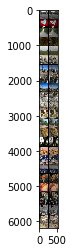

[Epoch 0/200] [Batch 200/209]  [G loss: -0.589708] [L1 loss: 0.052477] [l2 loss: 0.006318] [SSIM: -0.648503]


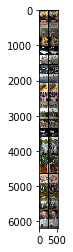

[Epoch 1/200] [Batch 191/209]  [G loss: -0.592326] [L1 loss: 0.051857] [l2 loss: 0.006211] [SSIM: -0.650393]


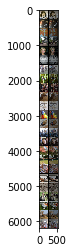

[Epoch 2/200] [Batch 182/209]  [G loss: -0.593669] [L1 loss: 0.051832] [l2 loss: 0.006205] [SSIM: -0.651706]


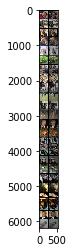

[Epoch 3/200] [Batch 173/209]  [G loss: -0.591820] [L1 loss: 0.051966] [l2 loss: 0.006214] [SSIM: -0.650000]


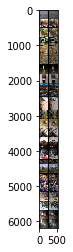

[Epoch 4/200] [Batch 164/209]  [G loss: -0.593229] [L1 loss: 0.051815] [l2 loss: 0.006196] [SSIM: -0.651239]


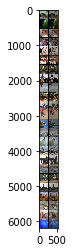

[Epoch 5/200] [Batch 155/209]  [G loss: -0.594027] [L1 loss: 0.052014] [l2 loss: 0.006263] [SSIM: -0.652303]


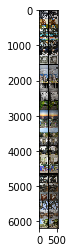

[Epoch 6/200] [Batch 146/209]  [G loss: -0.596956] [L1 loss: 0.051239] [l2 loss: 0.006049] [SSIM: -0.654244]


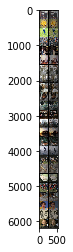

[Epoch 7/200] [Batch 137/209]  [G loss: -0.594628] [L1 loss: 0.051604] [l2 loss: 0.006187] [SSIM: -0.652419]


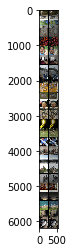

[Epoch 8/200] [Batch 128/209]  [G loss: -0.593610] [L1 loss: 0.051732] [l2 loss: 0.006173] [SSIM: -0.651515]


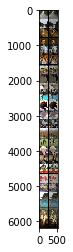

[Epoch 9/200] [Batch 119/209]  [G loss: -0.593647] [L1 loss: 0.051903] [l2 loss: 0.006235] [SSIM: -0.651785]


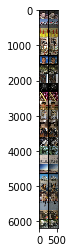

[Epoch 10/200] [Batch 110/209]  [G loss: -0.597588] [L1 loss: 0.051040] [l2 loss: 0.006069] [SSIM: -0.654696]


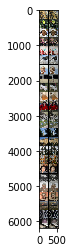

[Epoch 11/200] [Batch 101/209]  [G loss: -0.595786] [L1 loss: 0.051527] [l2 loss: 0.006157] [SSIM: -0.653471]


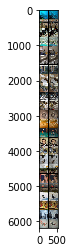

[Epoch 12/200] [Batch 92/209]  [G loss: -0.595459] [L1 loss: 0.051100] [l2 loss: 0.006070] [SSIM: -0.652629]


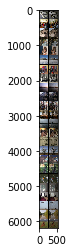

[Epoch 13/200] [Batch 83/209]  [G loss: -0.599030] [L1 loss: 0.050874] [l2 loss: 0.005979] [SSIM: -0.655883]


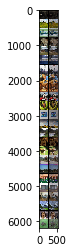

[Epoch 14/200] [Batch 74/209]  [G loss: -0.597697] [L1 loss: 0.052263] [l2 loss: 0.006198] [SSIM: -0.656157]


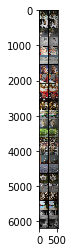

[Epoch 15/200] [Batch 65/209]  [G loss: -0.603930] [L1 loss: 0.050499] [l2 loss: 0.005955] [SSIM: -0.660384]


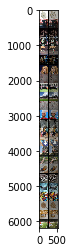

[Epoch 16/200] [Batch 56/209]  [G loss: -0.604020] [L1 loss: 0.050460] [l2 loss: 0.005968] [SSIM: -0.660449]


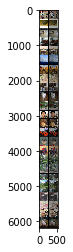

[Epoch 17/200] [Batch 47/209]  [G loss: -0.602657] [L1 loss: 0.050542] [l2 loss: 0.006037] [SSIM: -0.659236]


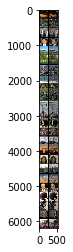

[Epoch 18/200] [Batch 38/209]  [G loss: -0.594699] [L1 loss: 0.052117] [l2 loss: 0.006393] [SSIM: -0.653208]


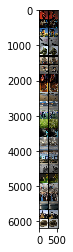

[Epoch 19/200] [Batch 29/209]  [G loss: -0.604814] [L1 loss: 0.051006] [l2 loss: 0.005955] [SSIM: -0.661775]


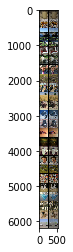

[Epoch 20/200] [Batch 20/209]  [G loss: -0.603821] [L1 loss: 0.051185] [l2 loss: 0.006050] [SSIM: -0.661056]


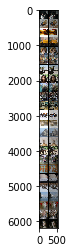

[Epoch 21/200] [Batch 11/209]  [G loss: -0.587502] [L1 loss: 0.052237] [l2 loss: 0.006302] [SSIM: -0.646041]


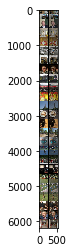

[Epoch 22/200] [Batch 2/209]  [G loss: -0.607499] [L1 loss: 0.049241] [l2 loss: 0.005921] [SSIM: -0.662661]


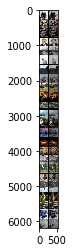

[Epoch 22/200] [Batch 202/209]  [G loss: -0.602012] [L1 loss: 0.050621] [l2 loss: 0.005999] [SSIM: -0.658633]


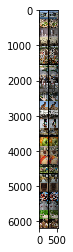

[Epoch 23/200] [Batch 193/209]  [G loss: -0.602312] [L1 loss: 0.050589] [l2 loss: 0.006004] [SSIM: -0.658905]


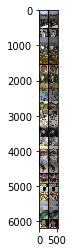

[Epoch 24/200] [Batch 184/209]  [G loss: -0.602294] [L1 loss: 0.050706] [l2 loss: 0.006009] [SSIM: -0.659008]


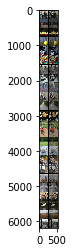

[Epoch 25/200] [Batch 175/209]  [G loss: -0.603692] [L1 loss: 0.050335] [l2 loss: 0.005944] [SSIM: -0.659971]


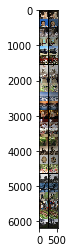

[Epoch 26/200] [Batch 166/209]  [G loss: -0.598646] [L1 loss: 0.050777] [l2 loss: 0.006025] [SSIM: -0.655447]


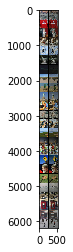

[Epoch 27/200] [Batch 157/209]  [G loss: -0.596628] [L1 loss: 0.051156] [l2 loss: 0.006057] [SSIM: -0.653840]


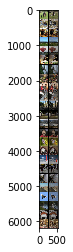

[Epoch 28/200] [Batch 148/209]  [G loss: -0.598553] [L1 loss: 0.051029] [l2 loss: 0.006018] [SSIM: -0.655599]


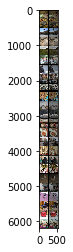

[Epoch 29/200] [Batch 139/209]  [G loss: -0.604842] [L1 loss: 0.050268] [l2 loss: 0.005887] [SSIM: -0.660998]


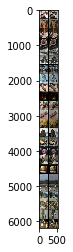

[Epoch 30/200] [Batch 130/209]  [G loss: -0.599406] [L1 loss: 0.050841] [l2 loss: 0.006054] [SSIM: -0.656301]


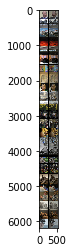

[Epoch 31/200] [Batch 121/209]  [G loss: -0.603803] [L1 loss: 0.050350] [l2 loss: 0.005936] [SSIM: -0.660089]


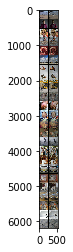

[Epoch 32/200] [Batch 112/209]  [G loss: -0.606683] [L1 loss: 0.049732] [l2 loss: 0.005815] [SSIM: -0.662230]


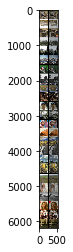

[Epoch 33/200] [Batch 103/209]  [G loss: -0.588515] [L1 loss: 0.052246] [l2 loss: 0.006212] [SSIM: -0.646973]


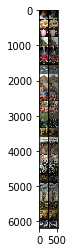

[Epoch 34/200] [Batch 94/209]  [G loss: -0.604044] [L1 loss: 0.049834] [l2 loss: 0.005794] [SSIM: -0.659672]


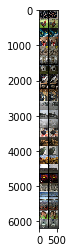

[Epoch 35/200] [Batch 85/209]  [G loss: -0.605338] [L1 loss: 0.049905] [l2 loss: 0.005778] [SSIM: -0.661020]


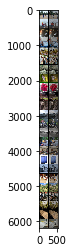

[Epoch 36/200] [Batch 76/209]  [G loss: -0.604222] [L1 loss: 0.050390] [l2 loss: 0.005880] [SSIM: -0.660492]


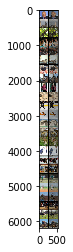

[Epoch 37/200] [Batch 67/209]  [G loss: -0.604958] [L1 loss: 0.050024] [l2 loss: 0.005849] [SSIM: -0.660832]


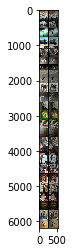

[Epoch 38/200] [Batch 58/209]  [G loss: -0.604892] [L1 loss: 0.050603] [l2 loss: 0.006002] [SSIM: -0.661497]


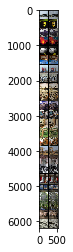

[Epoch 39/200] [Batch 49/209]  [G loss: -0.601934] [L1 loss: 0.050820] [l2 loss: 0.006086] [SSIM: -0.658840]


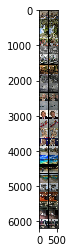

[Epoch 40/200] [Batch 40/209]  [G loss: -0.609018] [L1 loss: 0.049977] [l2 loss: 0.005851] [SSIM: -0.664846]


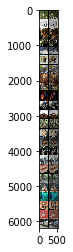

[Epoch 41/200] [Batch 31/209]  [G loss: -0.603002] [L1 loss: 0.049967] [l2 loss: 0.005890] [SSIM: -0.658858]


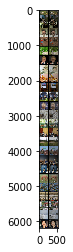

[Epoch 42/200] [Batch 22/209]  [G loss: -0.611243] [L1 loss: 0.049278] [l2 loss: 0.005748] [SSIM: -0.666269]


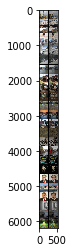

[Epoch 43/200] [Batch 13/209]  [G loss: -0.613056] [L1 loss: 0.049697] [l2 loss: 0.005736] [SSIM: -0.668489]


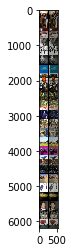

[Epoch 44/200] [Batch 4/209]  [G loss: -0.603439] [L1 loss: 0.051599] [l2 loss: 0.006097] [SSIM: -0.661135]


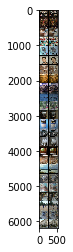

[Epoch 44/200] [Batch 204/209]  [G loss: -0.607309] [L1 loss: 0.049902] [l2 loss: 0.005873] [SSIM: -0.663084]


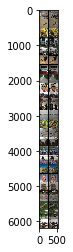

[Epoch 45/200] [Batch 195/209]  [G loss: -0.607002] [L1 loss: 0.050106] [l2 loss: 0.005911] [SSIM: -0.663018]


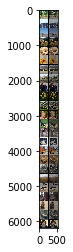

[Epoch 46/200] [Batch 186/209]  [G loss: -0.607469] [L1 loss: 0.050031] [l2 loss: 0.005884] [SSIM: -0.663385]


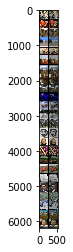

[Epoch 47/200] [Batch 177/209]  [G loss: -0.608264] [L1 loss: 0.050006] [l2 loss: 0.005894] [SSIM: -0.664164]


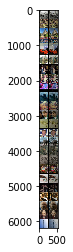

[Epoch 48/200] [Batch 168/209]  [G loss: -0.608339] [L1 loss: 0.049985] [l2 loss: 0.005873] [SSIM: -0.664198]


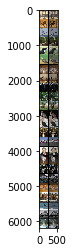

[Epoch 49/200] [Batch 159/209]  [G loss: -0.607854] [L1 loss: 0.049956] [l2 loss: 0.005891] [SSIM: -0.663701]


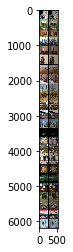

[Epoch 50/200] [Batch 150/209]  [G loss: -0.608679] [L1 loss: 0.049817] [l2 loss: 0.005865] [SSIM: -0.664361]


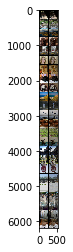

[Epoch 51/200] [Batch 141/209]  [G loss: -0.609032] [L1 loss: 0.050153] [l2 loss: 0.005918] [SSIM: -0.665103]


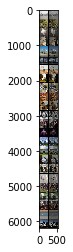

[Epoch 52/200] [Batch 132/209]  [G loss: -0.607762] [L1 loss: 0.050103] [l2 loss: 0.005904] [SSIM: -0.663769]


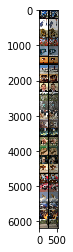

[Epoch 53/200] [Batch 123/209]  [G loss: -0.603903] [L1 loss: 0.050706] [l2 loss: 0.005964] [SSIM: -0.660573]


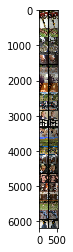

[Epoch 54/200] [Batch 114/209]  [G loss: -0.608403] [L1 loss: 0.049958] [l2 loss: 0.005887] [SSIM: -0.664248]


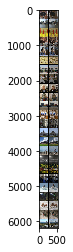

[Epoch 55/200] [Batch 105/209]  [G loss: -0.606386] [L1 loss: 0.050122] [l2 loss: 0.005942] [SSIM: -0.662449]


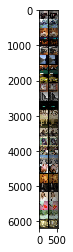

[Epoch 56/200] [Batch 96/209]  [G loss: -0.609530] [L1 loss: 0.049695] [l2 loss: 0.005797] [SSIM: -0.665022]


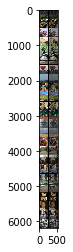

[Epoch 57/200] [Batch 87/209]  [G loss: -0.607653] [L1 loss: 0.050028] [l2 loss: 0.005924] [SSIM: -0.663605]


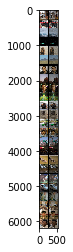

[Epoch 58/200] [Batch 78/209]  [G loss: -0.606444] [L1 loss: 0.050290] [l2 loss: 0.006011] [SSIM: -0.662745]


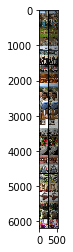

[Epoch 59/200] [Batch 69/209]  [G loss: -0.609054] [L1 loss: 0.050066] [l2 loss: 0.005928] [SSIM: -0.665049]


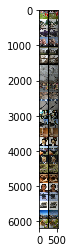

[Epoch 60/200] [Batch 60/209]  [G loss: -0.609126] [L1 loss: 0.049930] [l2 loss: 0.005856] [SSIM: -0.664911]


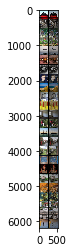

[Epoch 61/200] [Batch 51/209]  [G loss: -0.608380] [L1 loss: 0.050276] [l2 loss: 0.005960] [SSIM: -0.664617]


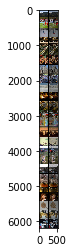

[Epoch 62/200] [Batch 42/209]  [G loss: -0.612182] [L1 loss: 0.048980] [l2 loss: 0.005703] [SSIM: -0.666865]


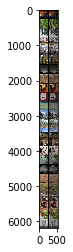

[Epoch 63/200] [Batch 33/209]  [G loss: -0.609897] [L1 loss: 0.050201] [l2 loss: 0.005860] [SSIM: -0.665958]


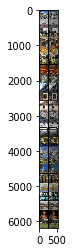

[Epoch 64/200] [Batch 24/209]  [G loss: -0.607116] [L1 loss: 0.049987] [l2 loss: 0.005934] [SSIM: -0.663037]


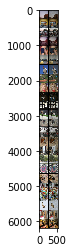

[Epoch 65/200] [Batch 15/209]  [G loss: -0.615926] [L1 loss: 0.048874] [l2 loss: 0.005730] [SSIM: -0.670531]


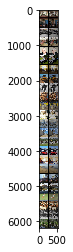

[Epoch 66/200] [Batch 6/209]  [G loss: -0.607854] [L1 loss: 0.049274] [l2 loss: 0.005735] [SSIM: -0.662863]


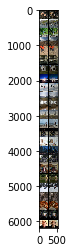

[Epoch 66/200] [Batch 206/209]  [G loss: -0.609884] [L1 loss: 0.049770] [l2 loss: 0.005842] [SSIM: -0.665496]


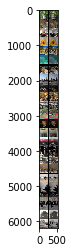

Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, b

KeyboardInterrupt: ignored

In [0]:
# ----------
#  Training
# ----------
std_1= Tensor(std).unsqueeze(0).unsqueeze(2).unsqueeze(3)
mean_1= Tensor(mean).unsqueeze(0).unsqueeze(2).unsqueeze(3) 
for epoch in range(epochs):
    if epoch % checkpoint_interval == 0:
        # Save model checkpoints
          torch.save(generator.state_dict(), "/content/drive/My Drive/DL/ckpt_1/generator_%d.pth" % epoch)
          torch.save(discriminator.state_dict(), "/content/drive/My Drive/DL/ckpt_1/discriminator_%d.pth" % epoch)

    
    for i, imgs in enumerate(dataloader):
        
        # Configure model input
        imgs_lr = Variable(imgs["lr"].type(Tensor))
        imgs_hr = Variable(imgs["hr"].type(Tensor))
        # ------------------
        #  Train Generators
        # ------------------
        optimizer_G.zero_grad()

        # Generate a high resolution image from low resolution input
        
        gen_hr = generator(imgs_lr)

        
        # Content loss
        loss_ssim = -1*criterion_SSIM(gen_hr, imgs_hr)
        loss_img = criterion_L1(gen_hr, imgs_hr)
        loss_img_l2 = criterion_L2(gen_hr, imgs_hr)
        # Total loss
        loss_G =  loss_img + loss_img_l2+loss_ssim
        loss_G.backward()
        optimizer_G.step()
        
        # --------------
        #  Log Progress
        # --------------

  
        batches_done = epoch * len(dataloader) + i
        if batches_done % 200 == 0:
            sys.stdout.write(
            "[Epoch %d/%d] [Batch %d/%d]  [G loss: %f] [L1 loss: %f] [l2 loss: %f] [SSIM: %f]\n"
            % (epoch, epochs, i, len(dataloader), loss_G.item(), loss_img.item(), loss_img_l2.item(), loss_ssim.item())
        )

            # Save image grid with upsampled inputs and SRGAN outputs
            imgs_lr = nn.functional.interpolate(imgs_lr, scale_factor=4)
            gen_hr = make_grid(gen_hr, nrow=1, normalize=True)
            imgs_lr = make_grid(imgs_lr, nrow=1, normalize=True)
            img_grid = torch.cat((imgs_lr, gen_hr), -1)
            import matplotlib.pyplot as plt
            image = np.moveaxis(img_grid.detach().cpu().numpy(),0,-1)
            plt.imshow(image)
            plt.show()
             
    if epoch % checkpoint_interval == 0:
        # Save model checkpoints
        torch.save(generator.state_dict(), "/content/drive/My Drive/DL/ckpt_1/generator_%d.pth" % epoch)
        torch.save(discriminator.state_dict(), "/content/drive/My Drive/DL/ckpt_1/discriminator_%d.pth" % epoch)
